# Notebook 1.3: Solving QPs & Basic LMPC (Unconstrained)

In the previous notebook (1.2), we successfully formulated the Linear Model Predictive Control (LMPC) problem as a Quadratic Program (QP) by deriving the matrices $\mathbf{H}_{QP}$ and $\mathbf{f}_{QP}$. Now, it's time to solve this QP to find the optimal sequence of future control inputs and then implement the core receding horizon control loop.

For this notebook, we will focus on **unconstrained LMPC**. We'll introduce constraints in Notebook 1.4. This will allow us to concentrate on the QP solution and the basic MPC feedback mechanism first.

**Goals of this Notebook:**
1. Introduce how to solve QPs in Python using libraries like `CVXPY`.
2. Implement the unconstrained LMPC receding horizon loop:
    a. Obtain the current system state.
    b. Formulate and solve the QP to get the optimal control sequence $\mathbf{U}_k^*$.
    c. Apply the first control input $u_{k|k}^*$ from this sequence to a simulated plant.
    d. Repeat for a defined simulation duration.
3. Visualize the closed-loop performance of the LMPC controller on our double integrator example for a setpoint tracking task.
4. Experiment with MPC tuning weights ($\mathbf{Q}_w, \mathbf{R}_w, \mathbf{S}_w$) and observe their impact on performance.

## 1. Importing Libraries and Re-using Code

We'll need NumPy, Matplotlib, `scipy.signal.cont2discrete`, and a QP solver. We'll use `CVXPY` as a user-friendly modeling language for convex optimization problems, which can interface with various underlying QP solvers like OSQP or ECOS (which are often installed as dependencies or can be specified).

**Installation (if you haven't already):**
Make sure your virtual environment from Notebook 0.0 is activated.
```bash
uv pip install cvxpy osqp # ECOS is another good open-source solver CVXPY can use
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete
import cvxpy as cp

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 7)})

# --- Code from Notebook 1.1 & 1.2 ---
# System Definition (Double Integrator)
Ac = np.array([[0, 1], [0, 0]])
Bc = np.array([[0], [1]])
Cc = np.array([[1, 0]])
Dc = np.array([[0]])
Ts = 0.1
Ad, Bd, Cd, Dd, _ = cont2discrete((Ac, Bc, Cc, Dc), Ts, method='zoh')
n_states = Ad.shape[0]
n_inputs = Bd.shape[1]
n_outputs = Cd.shape[0]

# Prediction Matrices Function (from Notebook 1.1 - final version)
def get_prediction_matrices(Ad_sys, Bd_sys, Cd_sys, Np_horizon):
    n_s = Ad_sys.shape[0]
    n_i = Bd_sys.shape[1]
    n_o = Cd_sys.shape[0]
    F = np.zeros((n_o * Np_horizon, n_s))
    Phi = np.zeros((n_o * Np_horizon, n_i * Np_horizon))
    for i in range(Np_horizon):
        F[i*n_o:(i+1)*n_o, :] = Cd_sys @ np.linalg.matrix_power(Ad_sys, i + 1)
        for j in range(i + 1):
            if i-j == 0:
                 Phi[i*n_o:(i+1)*n_o, j*n_i:(j+1)*n_i] = Cd_sys @ Bd_sys
            else:
                 Phi[i*n_o:(i+1)*n_o, j*n_i:(j+1)*n_i] = Cd_sys @ np.linalg.matrix_power(Ad_sys, i-j) @ Bd_sys
    return F, Phi

# QP Matrices Function (from Notebook 1.2)
def build_qp_matrices(F_mat, Phi_mat, Q_val, R_val, S_val, Np_horizon, m_ins, p_outs, u_prev_val):
    Q_matrix = Q_val * np.eye(p_outs)
    R_matrix = R_val * np.eye(m_ins)
    S_matrix = S_val * np.eye(m_ins)
    
    Q_bar = np.kron(np.eye(Np_horizon), Q_matrix)
    R_bar = np.kron(np.eye(Np_horizon), R_matrix)
    S_bar = np.kron(np.eye(Np_horizon), S_matrix)
    
    T_diff = np.zeros((Np_horizon * m_ins, Np_horizon * m_ins))
    for i in range(Np_horizon):
        T_diff[i*m_ins:(i+1)*m_ins, i*m_ins:(i+1)*m_ins] = np.eye(m_ins)
        if i > 0:
            T_diff[i*m_ins:(i+1)*m_ins, (i-1)*m_ins:i*m_ins] = -np.eye(m_ins)
            
    U_prev_stacked = np.zeros((Np_horizon * m_ins, 1))
    U_prev_stacked[0:m_ins, 0] = u_prev_val.flatten()
    
    H_qp = 2 * (Phi_mat.T @ Q_bar @ Phi_mat + R_bar + T_diff.T @ S_bar @ T_diff)
    
    # Inner function to compute f_qp as it depends on xk and R_traj
    def compute_f_qp(xk_current, R_traj_vec):
        error_term_Fx_R = F_mat @ xk_current - R_traj_vec
        f_qp = 2 * (Phi_mat.T @ Q_bar @ error_term_Fx_R - T_diff.T @ S_bar @ U_prev_stacked)
        return f_qp
        
    return H_qp, compute_f_qp

# MPC Parameters
Np = 20      # Prediction Horizon
Nc = Np      # Control Horizon (U decision vector has Nc*m elements)
             # For simplicity, Phi_matrix will be Np*p x Np*m. If Nc<Np, adjustments needed.
             # In build_qp_matrices, R_bar & S_bar should be Nc*m x Nc*m and T_diff Nc*m x Nc*m.
             # And Phi needs to be (Np*p x Nc*m). Let's assume Np=Nc for now.

Qw = 100.0   # Output error weight
Rw = 0.1    # Input magnitude weight
Sw = 1.0     # Input rate weight

# Get prediction matrices for the chosen Np
F_mpc, Phi_mpc = get_prediction_matrices(Ad, Bd, Cd, Np)

## 2. Solving Quadratic Programs with CVXPY

CVXPY is a Python-embedded modeling language for convex optimization problems. It allows you to specify optimization problems in a natural mathematical syntax.

The standard form for a QP that many solvers (and CVXPY) use is:
$$ \text{minimize} \quad \frac{1}{2} \mathbf{z}^T P \mathbf{z} + \mathbf{q}^T \mathbf{z} $$
$$ \text{subject to} \quad G \mathbf{z} \le h $$
$$ \quad \quad \quad \quad A_{eq} \mathbf{z} = b_{eq} $$

In our case, $\mathbf{z} = \mathbf{U}_k$, $P = \mathbf{H}_{QP}$, and $\mathbf{q} = \mathbf{f}_{QP}$. For this unconstrained notebook, we won't have $G, h, A_{eq}, b_{eq}$ yet.

In [2]:
def solve_qp_cvxpy(H_qp, f_qp, solver=cp.OSQP):
    """
    Solves an unconstrained QP problem: min 0.5*U.T @ H_qp @ U + f_qp.T @ U
    using CVXPY.
    
    Args:
        H_qp: (Np*m x Np*m) positive (semi-)definite matrix.
        f_qp: (Np*m x 1) vector.
        solver: CVXPY solver to use (e.g., cp.OSQP, cp.ECOS).
        
    Returns:
        U_optimal: Optimal control sequence (Np*m x 1), or None if failed.
    """
    num_vars = H_qp.shape[0]
    U = cp.Variable(num_vars)
    
    # CVXPY expects P (H_qp) and q (f_qp) for 0.5 * x'Px + q'x
    # Our f_qp was derived for Hx + f (factor of 2 in H,f). So if H_qp already has the 2, use it directly.
    # If H_qp is 2*(...), f_qp is 2*(...), then obj = 0.5 U' (0.5 H_qp_orig) U + (0.5 f_qp_orig)' U
    # Let's assume H_qp and f_qp are from our derivation where factor of 2 is already included
    # so we want to minimize 0.5 * U.T @ (0.5*H_qp) @ U + (0.5*f_qp).T @ U.
    # OR, if H_qp is the Hessian of J, and f_qp is the gradient of J w.r.t U (linear part), then
    # J = J_const + f_qp_lin^T U + 0.5 U^T H_qp_hess U.
    # So P = H_qp_hess, q = f_qp_lin.
    # Our derivation was: H_QP = 2 * (...), f_QP = 2 * (...)
    # Objective in QP form: 0.5 * U.T @ P_cvx @ U + q_cvx.T @ U
    # Original full objective: U.T @ (0.5 * H_QP_from_deriv) @ U + f_QP_from_deriv.T @ U
    # So, P_cvx = H_QP_from_deriv, q_cvx = f_QP_from_deriv
    # The build_qp_matrices already includes the factor of 2.
    # So P_cvx = H_qp, q_cvx = f_qp for obj = 0.5 U' H_qp U + f_qp' U, this is not standard.
    # Standard is 0.5 U' P U + q' U. Our H_qp = P, f_qp = q.

    # Objective is 0.5 * U.T @ H_qp @ U + f_qp.T @ U
    # Note: H_qp must be positive semi-definite for CVXPY to accept it for cp.quad_form.
    # We should ensure H_qp is symmetric.
    H_qp_symmetric = 0.5 * (H_qp + H_qp.T)
    
    objective = cp.Minimize(0.5 * cp.quad_form(U, H_qp_symmetric) + f_qp.flatten() @ U)
    problem = cp.Problem(objective)
    
    try:
        # Solve the problem
        problem.solve(solver=solver, verbose=False) # Set verbose=True for solver output
        if problem.status == cp.OPTIMAL or problem.status == cp.OPTIMAL_INACCURATE:
            return U.value.reshape(-1, 1)
        else:
            print(f"QP solution failed. Status: {problem.status}")
            return None
    except Exception as e:
        print(f"Error during QP solve: {e}")
        return None

## 3. Implementing the Unconstrained LMPC Loop

The MPC controller operates in a receding horizon fashion:
1.  At current time $k$, obtain the current state $x_k$ of the plant.
2.  Define the reference trajectory $R_{traj}$ for the prediction horizon.
3.  Using $x_k$, $R_{traj}$, and $u_{k-1}$ (previous input), compute $\mathbf{f}_{QP}$. ($\mathbf{H}_{QP}$ is constant if weights don't change).
4.  Solve the QP: $\min_{\mathbf{U}_k} \frac{1}{2} \mathbf{U}_k^T \mathbf{H}_{QP} \mathbf{U}_k + \mathbf{f}_{QP}^T \mathbf{U}_k$ to get $\mathbf{U}_k^* = [u_{k|k}^{*T}, u_{k+1|k}^{*T}, \dots, u_{k+N_p-1|k}^{*T}]^T$.
5.  Apply only the first control input $u_k = u_{k|k}^*$ to the plant.
6.  The plant evolves to a new state $x_{k+1}$. Update $u_{k-1} = u_k$.
7.  Increment $k$ and repeat from step 1.

In [3]:
# Simulation Parameters
sim_steps = 100  # Number of simulation steps

# Plant (Double Integrator - using Ad, Bd, Cd, Dd from above)
x_plant = np.array([[0.0], [0.0]])    # Initial state of the plant
y_plant = Cd @ x_plant + Dd @ np.array([[0.0]]) # Initial output (not really used in loop start)
u_prev_plant = np.array([[0.0]]) # Previous input applied to the plant

# Reference trajectory: step to position 1.0
setpoint = 1.0
R_traj_target = np.ones((Np * n_outputs, 1)) * setpoint

# Data logging
X_log = np.zeros((n_states, sim_steps + 1))
Y_log = np.zeros((n_outputs, sim_steps))
U_log = np.zeros((n_inputs, sim_steps))
X_log[:, 0] = x_plant.flatten()

# Pre-calculate H_qp as it's constant if weights don't change
# (u_prev will change, affecting f_qp, but H_qp is independent of u_prev)
# For H_qp, the u_prev argument to build_qp_matrices doesn't strictly matter for H part.
H_qp_mpc, compute_f_qp_mpc_func = build_qp_matrices(
    F_mpc, Phi_mpc, Qw, Rw, Sw, Np, n_inputs, n_outputs, u_prev_plant 
    # Pass a dummy u_prev for H_qp calculation, f_qp will use the correct one.
)

print(f"Starting LMPC simulation for {sim_steps} steps...")
for k_sim in range(sim_steps):
    print(f"Sim step {k_sim+1}/{sim_steps}", end='\r')
    # 1. Get current state (from plant simulation)
    x_current_plant = X_log[:, k_sim].reshape(n_states, 1)
    
    # 2. Define reference (R_traj_target is constant here)
    
    # 3. Compute f_qp (H_qp is already computed)
    # Re-build H_qp and f_qp function if u_prev in H_qp matters due to T_diff term strictly
    # Let's pass the current u_prev_plant to get the correct f_qp generating function
    # For H_qp, it doesn't depend on u_prev. The T_diff.T @ S_bar @ T_diff is constant.
    # The term involving u_prev is only in f_qp.
    if k_sim > 0:
        u_prev_for_f_qp = U_log[:, k_sim-1].reshape(n_inputs, 1)
    else:
        u_prev_for_f_qp = np.array([[0.0]]) # Initial previous input
    
    # Need to re-instantiate the f_qp function with the correct u_prev for that step
    # Alternatively, pass u_prev to compute_f_qp directly if modified
    # Let's modify build_qp_matrices so compute_f_qp takes u_prev_val as an argument

    # --- Modified QP Matrix Builder for Sim Loop ---
    def build_qp_matrices_for_sim(F_mat, Phi_mat, Q_val, R_val, S_val, Np_h, m_ins, p_outs):
        Q_matrix_s = Q_val * np.eye(p_outs)
        R_matrix_s = R_val * np.eye(m_ins)
        S_matrix_s = S_val * np.eye(m_ins)
        Q_bar_s = np.kron(np.eye(Np_h), Q_matrix_s)
        R_bar_s = np.kron(np.eye(Np_h), R_matrix_s)
        S_bar_s = np.kron(np.eye(Np_h), S_matrix_s)
        T_diff_s = np.zeros((Np_h * m_ins, Np_h * m_ins))
        for i in range(Np_h):
            T_diff_s[i*m_ins:(i+1)*m_ins, i*m_ins:(i+1)*m_ins] = np.eye(m_ins)
            if i > 0:
                T_diff_s[i*m_ins:(i+1)*m_ins, (i-1)*m_ins:i*m_ins] = -np.eye(m_ins)
        H_qp_s = 2 * (Phi_mat.T @ Q_bar_s @ Phi_mat + R_bar_s + T_diff_s.T @ S_bar_s @ T_diff_s)
        def compute_f_qp_inner(xk_curr, R_traj_v, u_prev_curr):
            U_prev_stacked_s = np.zeros((Np_h * m_ins, 1))
            U_prev_stacked_s[0:m_ins, 0] = u_prev_curr.flatten()
            error_term_Fx_R_s = F_mat @ xk_curr - R_traj_v
            f_qp_s = 2 * (Phi_mat.T @ Q_bar_s @ error_term_Fx_R_s - T_diff_s.T @ S_bar_s @ U_prev_stacked_s)
            return f_qp_s
        return H_qp_s, compute_f_qp_inner
    # --- End Modified QP Matrix Builder ---

    H_qp_mpc_sim, compute_f_qp_mpc_func_sim = build_qp_matrices_for_sim(
        F_mpc, Phi_mpc, Qw, Rw, Sw, Np, n_inputs, n_outputs
    )
    f_qp_current = compute_f_qp_mpc_func_sim(x_current_plant, R_traj_target, u_prev_plant)
    
    # 4. Solve QP
    U_optimal_seq = solve_qp_cvxpy(H_qp_mpc_sim, f_qp_current)
    
    if U_optimal_seq is None:
        print(f"QP Solver failed at step {k_sim+1}. Using previous control input.")
        u_applied = u_prev_plant
    else:
        # 5. Apply first control input
        u_applied = U_optimal_seq[0:n_inputs, 0].reshape(n_inputs, 1)
    
    U_log[:, k_sim] = u_applied.flatten()
    
    # 6. Plant evolves
    x_next_plant = Ad @ x_current_plant + Bd @ u_applied
    y_current_plant = Cd @ x_next_plant + Dd @ u_applied # Output at k+1 based on x_k+1, u_k
                                                    # Or y_current_plant = Cd @ x_current_plant + Dd @ u_applied for y_k
                                                    # Let's log y_k = C x_k (before applying u_k for this step for consistency)
    y_log_val = Cd @ x_current_plant # y_k = C x_k
    Y_log[:, k_sim] = y_log_val.flatten()
    X_log[:, k_sim + 1] = x_next_plant.flatten()
    
    # 7. Update u_prev for next iteration
    u_prev_plant = u_applied

print("\nLMPC simulation finished.")

Starting LMPC simulation for 100 steps...
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not

## 4. Visualizing Closed-Loop Performance

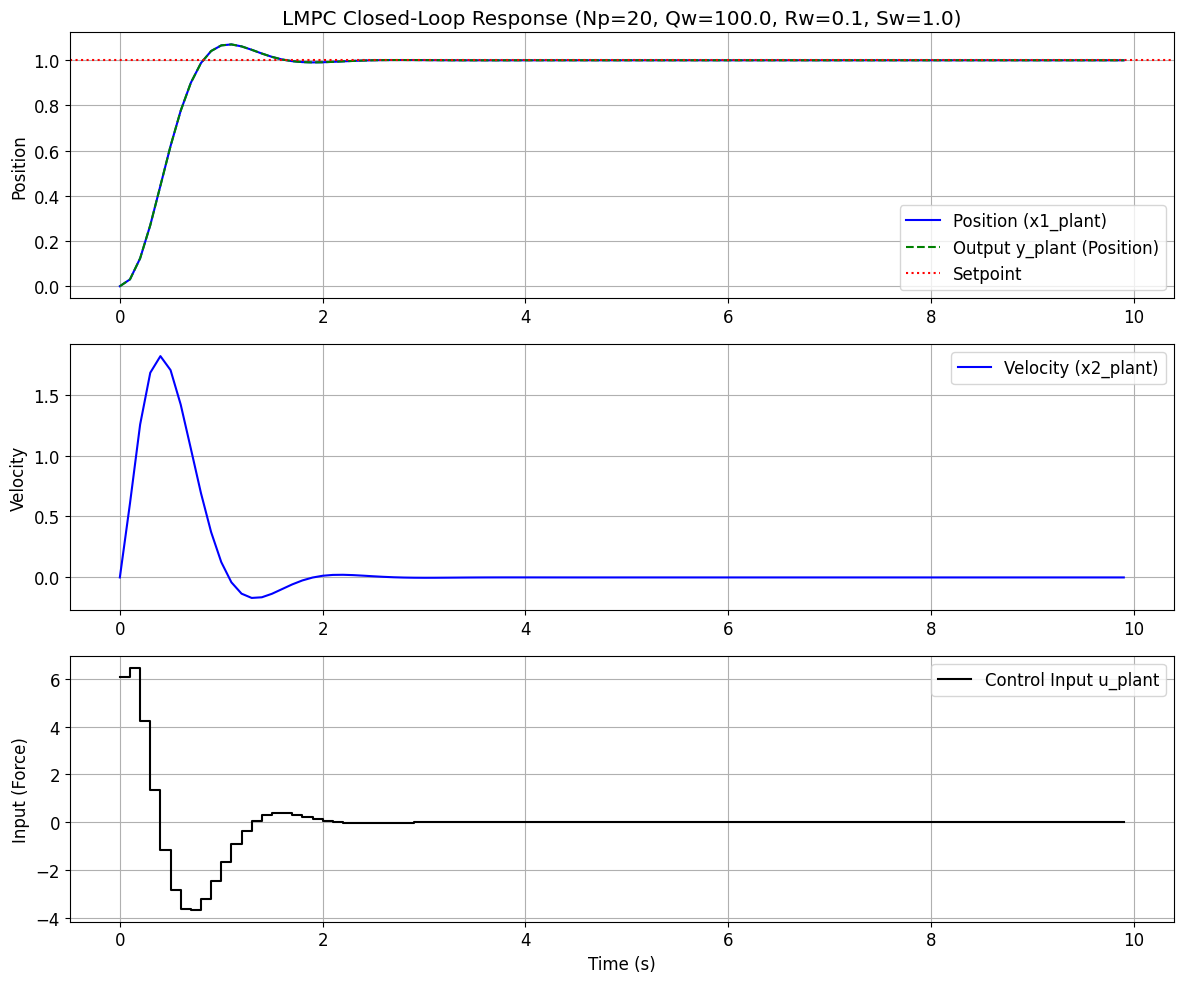

In [5]:
time_vec = np.arange(0, sim_steps * Ts, Ts)
time_vec_states = np.arange(0, (sim_steps + 1) * Ts, Ts)

plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
plt.plot(time_vec, X_log[0,:-1], 'b-', label='Position (x1_plant)')  # Use :-1 to exclude last state
plt.plot(time_vec, Y_log[0,:], 'g--', label='Output y_plant (Position)')
plt.axhline(setpoint, color='r', linestyle=':', label='Setpoint')
plt.title(f'LMPC Closed-Loop Response (Np={Np}, Qw={Qw}, Rw={Rw}, Sw={Sw})')
plt.ylabel('Position')
plt.grid(True)
plt.legend()

plt.subplot(3,1,2)
plt.plot(time_vec, X_log[1,:-1], 'b-', label='Velocity (x2_plant)')  # Use :-1 to exclude last state
plt.ylabel('Velocity')
plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.step(time_vec, U_log[0,:], 'k-', where='post', label='Control Input u_plant')
plt.ylabel('Input (Force)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 5. Experimenting with Tuning Weights

Now, try changing the values of `Qw`, `Rw`, and `Sw` at the beginning of the simulation loop (or re-run the whole notebook with new values). Observe how the closed-loop response changes:

*   **Increasing `Qw` (output error weight):** Should make the controller track the setpoint more aggressively (faster response, potentially more overshoot or control effort).
*   **Increasing `Rw` (input magnitude weight):** Should lead to smaller control inputs, potentially a slower or more sluggish response.
*   **Increasing `Sw` (input rate weight):** Should lead to smoother changes in the control input, reducing chattering but possibly slowing down the response to sudden changes.

**Exercise:**
1.  Run the simulation with the default weights.
2.  Try significantly increasing `Qw` (e.g., to 1000.0) while keeping `Rw` and `Sw` the same. Observe the change.
3.  Reset `Qw`, then try significantly increasing `Rw` (e.g., to 10.0). Observe.
4.  Reset `Rw`, then try significantly increasing `Sw` (e.g., to 50.0). Observe.

This experimentation will give you an intuitive feel for MPC tuning.

## 6. Key Takeaways

*   QP solvers like those accessible via `CVXPY` can efficiently find the optimal control sequence $\mathbf{U}_k^*$ that minimizes the LMPC objective function.
*   The LMPC receding horizon loop involves repeatedly solving this QP at each time step based on the current state and applying only the first element of $\mathbf{U}_k^*$.
*   Tuning weights ($\mathbf{Q}_w, \mathbf{R}_w, \mathbf{S}_w$) and horizons ($N_p$) significantly influence the closed-loop performance, achieving a trade-off between responsiveness, control effort, and smoothness.

In the next notebook (**Notebook 1.4: LMPC with Input and Output Constraints**), we will add an essential feature of MPC: the ability to handle constraints explicitly within the QP optimization.